In [1]:
import requests
import pandas as pd
import re
import time
import os
import random
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from bs4 import BeautifulSoup
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
import nltk
from nltk.tokenize import word_tokenize
import csv
import spacy
from collections import Counter
from textblob import TextBlob
from nltk.corpus import stopwords
from scipy.stats import pearsonr

In [2]:
# Set up necessary directories and configurations:
os.makedirs('data', exist_ok=True)
session = requests.Session()
retries = Retry(total=3, backoff_factor=1, status_forcelist=[500, 502, 503, 504])
session.mount('http://', HTTPAdapter(max_retries=retries))
session.mount('https://', HTTPAdapter(max_retries=retries))
nltk.download('punkt')

# Clean title by removing author names:
def clean_title(title):
    # Remove any mention of "by" or "with" along with author names (e.g., "by H. P. Lovecraft")
    title = re.sub(r'(by\s*H\.?\s*P\.?\s*Lovecraft|with\s*H\.?\s*P\.?\s*Lovecraft)', '', title, flags=re.IGNORECASE).strip()

    # Remove any other remaining author mentions (like "By C. M. Eddy, Jr." etc.)
    title = re.sub(r'(by\s+[a-zA-Z\.\,]+)', '', title, flags=re.IGNORECASE).strip()

    # Remove extra spaces or redundant punctuation
    title = ' '.join(title.split())
    
    return title

# Scraping Lovecraft Fiction:
def scrape_lovecraft_content():
    base_url = "https://www.hplovecraft.com/writings/texts/"
    response = session.get(base_url)
    
    if response.status_code != 200:
        print(f"Failed to access the base URL: {response.status_code}")
        return
    
    soup = BeautifulSoup(response.content, 'html.parser')
    content_links = [
        f"{base_url}{link['href']}"
        for link in soup.find_all('a', href=True)
        if link['href'].startswith('fiction/') and not link['href'].startswith('#')
    ]

    csv_filename = 'data/lovecraft_fiction.csv'
    with open(csv_filename, 'w', newline='', encoding='utf-8') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(['Content Type', 'Title', 'Text'])

        for content_url in content_links:
            time.sleep(random.uniform(1, 3))
            try:
                content_response = session.get(content_url, headers={'User-Agent': 'Mozilla/5.0'})
                if content_response.status_code == 200:
                    content_soup = BeautifulSoup(content_response.content, 'html.parser')
                    title_tag = content_soup.find('font', size="+2")
                    text_div = content_soup.find('div', align='justify')

                    if title_tag and text_div:
                        title = title_tag.get_text(strip=True)
                        title = clean_title(title)  # Clean the title to remove authors
                        csvwriter.writerow(["fiction", title, text_div.get_text(strip=True)])
                        print(f'Scraped: {title}')
                    else:
                        print(f'Title or text not found for {content_url}')
                else:
                    print(f'Failed to scrape {content_url}: {content_response.status_code}')
            except Exception as e:
                print(f'Error scraping {content_url}: {e}')

scrape_lovecraft_content()


[nltk_data] Downloading package punkt to C:\Users\Marc
[nltk_data]     Jay/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Scraped: The Alchemist
Scraped: Ashes M. Eddy, Jr.
Scraped: At the Mountains of Madness
Scraped: Azathoth
Scraped: The Battle that Ended the Century(MS. Found in a Time Machine) H. Barlow
Scraped: The Beast in the Cave
Scraped: Beyond the Wall of Sleep
Scraped: The Book
Scraped: The Call of Cthulhu
Scraped: The Case of Charles Dexter Ward
Scraped: The Cats of Ulthar
Scraped: Celephaïs
Scraped: The Challenge from Beyond Moore, A. Merritt, H.P. Lovecraft,Robert E. Howard, and Frank Belknap Long
Scraped: Collapsing Cosmoses H. Barlowand H. P. Lovecraft
Scraped: The Colour out of Space
Scraped: Cool Air
Scraped: The Crawling Chaoswith Winifred V. Jackson
Scraped: The Curse of Yigfor Zealia Bishop
Scraped: Dagon
Scraped: Deaf, Dumb, and Blind M. Eddy, Jr.and H. P. Lovecraft
Scraped: The Descendant
Scraped: The Diary of Alonzo Typerfor William Lumley
Scraped: The Disinterment W. Rimeland H. P. Lovecraft
Scraped: The Doom That Came to Sarnath
Scraped: The Dream-Quest of Unknown Kadath
Scraped

In [3]:
# Load scraped CSV data into DF:
df = pd.read_csv('data/lovecraft_fiction.csv')

# View first few rows:
print(df.head())

# Count number of words per story:
df['Word Count'] = df['Text'].apply(lambda text: len([word for word in text.split() if word.isalpha()]))

# View updated DF with word counts:
print(df[['Title', 'Word Count']].head())

# 1. Calculate Text Length:
df['Text Length'] = df['Text'].apply(len)

# 2. Perform Sentiment Analysis:
def get_sentiment(text):
    # Create a TextBlob object.
    blob = TextBlob(text)
    # Return the sentiment polarity.
    return blob.sentiment.polarity

# Apply sentiment analysis to each story:
df['Sentiment'] = df['Text'].apply(get_sentiment)

# View DF with Text Length and Sentiment columns:
print(df[['Title', 'Text Length', 'Sentiment']].head())


  Content Type                                              Title  \
0      fiction                                      The Alchemist   
1      fiction                                 Ashes M. Eddy, Jr.   
2      fiction                        At the Mountains of Madness   
3      fiction                                           Azathoth   
4      fiction  The Battle that Ended the Century(MS. Found in...   

                                                Text  
0  High up, crowning the grassy summit of a swell...  
1  “Hello, Bruce. Haven’t seen you in a dog’s age...  
2  I.I am forced into speech because men of scien...  
3  When age fell upon the world, and wonder went ...  
4  [Note: Barlow’s contributions are in brackets....  
                                               Title  Word Count
0                                      The Alchemist        3252
1                                 Ashes M. Eddy, Jr.        2557
2                        At the Mountains of Madness       3

In [4]:
# Group by Word Count, Text Length (Character Count), and Sentiment, then get the frequency of each combination:
grouped_df = df.groupby(['Title', 'Word Count', 'Text Length', 'Sentiment']).size().reset_index(name='Frequency')

# View head and tail of the grouped DF:
print("Head of the grouped dataframe:")
print(grouped_df.head())

print("\nTail of the grouped dataframe:")
print(grouped_df.tail())


Head of the grouped dataframe:
                                  Title  Word Count  Text Length  Sentiment  \
0  A Reminiscence of Dr. Samuel Johnson        1477        11418   0.133794   
1                    Ashes M. Eddy, Jr.        2557        17467   0.039634   
2           At the Mountains of Madness       35200       247927   0.035509   
3                              Azathoth         431         2647  -0.055350   
4              Beyond the Wall of Sleep        3753        25195   0.045957   

   Frequency  
0          1  
1          1  
2          1  
3          1  
4          1  

Tail of the grouped dataframe:
                                               Title  Word Count  Text Length  \
100                  Two Black Bottles Blanch Talman        4011        26767   
101              Under the Pyramidsfor Harry Houdini        9414        63764   
102                             What the Moon Brings         638         3944   
103                     Winged Deathwith Hazel H

In [5]:
# Calculate total word count of all texts:
total_word_count = df['Word Count'].sum()

# Print total word count:
print(f"\nTotal Word Count Across All Texts: {total_word_count}")



Total Word Count Across All Texts: 611572


In [6]:
# Group by Title, Word Count, Text Length, and Sentiment, then get the frequency of each combination:
grouped_df = df.groupby(['Title', 'Word Count', 'Text Length', 'Sentiment']).size().reset_index(name='Frequency')

# Calculate average word count:
average_word_count = df['Word Count'].mean()

# Find title with the fewest and most words:
min_word_count = df['Word Count'].min()
max_word_count = df['Word Count'].max()

min_word_title = df[df['Word Count'] == min_word_count][['Title', 'Word Count']]
max_word_title = df[df['Word Count'] == max_word_count][['Title', 'Word Count']]

# Find highest and lowest sentiment scores:
min_sentiment = df['Sentiment'].min()
max_sentiment = df['Sentiment'].max()

min_sentiment_title = df[df['Sentiment'] == min_sentiment][['Title', 'Sentiment']]
max_sentiment_title = df[df['Sentiment'] == max_sentiment][['Title', 'Sentiment']]

# View head and tail of the grouped dataframe:
print("Head of the grouped dataframe:")
print(grouped_df.head())

print("\nTail of the grouped dataframe:")
print(grouped_df.tail())

# Print word count statistics:
print(f"\nAverage Word Count: {average_word_count:.2f}")
print(f"\nFewest Words: {min_word_count} (Title: {min_word_title.iloc[0]['Title']})")
print(f"Most Words: {max_word_count} (Title: {max_word_title.iloc[0]['Title']})")

# Print sentiment score statistics:
print(f"\nLowest Sentiment Score: {min_sentiment} (Title: {min_sentiment_title.iloc[0]['Title']})")
print(f"Highest Sentiment Score: {max_sentiment} (Title: {max_sentiment_title.iloc[0]['Title']})")


Head of the grouped dataframe:
                                  Title  Word Count  Text Length  Sentiment  \
0  A Reminiscence of Dr. Samuel Johnson        1477        11418   0.133794   
1                    Ashes M. Eddy, Jr.        2557        17467   0.039634   
2           At the Mountains of Madness       35200       247927   0.035509   
3                              Azathoth         431         2647  -0.055350   
4              Beyond the Wall of Sleep        3753        25195   0.045957   

   Frequency  
0          1  
1          1  
2          1  
3          1  
4          1  

Tail of the grouped dataframe:
                                               Title  Word Count  Text Length  \
100                  Two Black Bottles Blanch Talman        4011        26767   
101              Under the Pyramidsfor Harry Houdini        9414        63764   
102                             What the Moon Brings         638         3944   
103                     Winged Deathwith Hazel H

In [7]:
# Calculate total word count of all texts:
total_word_count = df['Word Count'].sum()

# Print total word count:
print(f"\nTotal Word Count Across All Texts: {total_word_count}")



Total Word Count Across All Texts: 611572


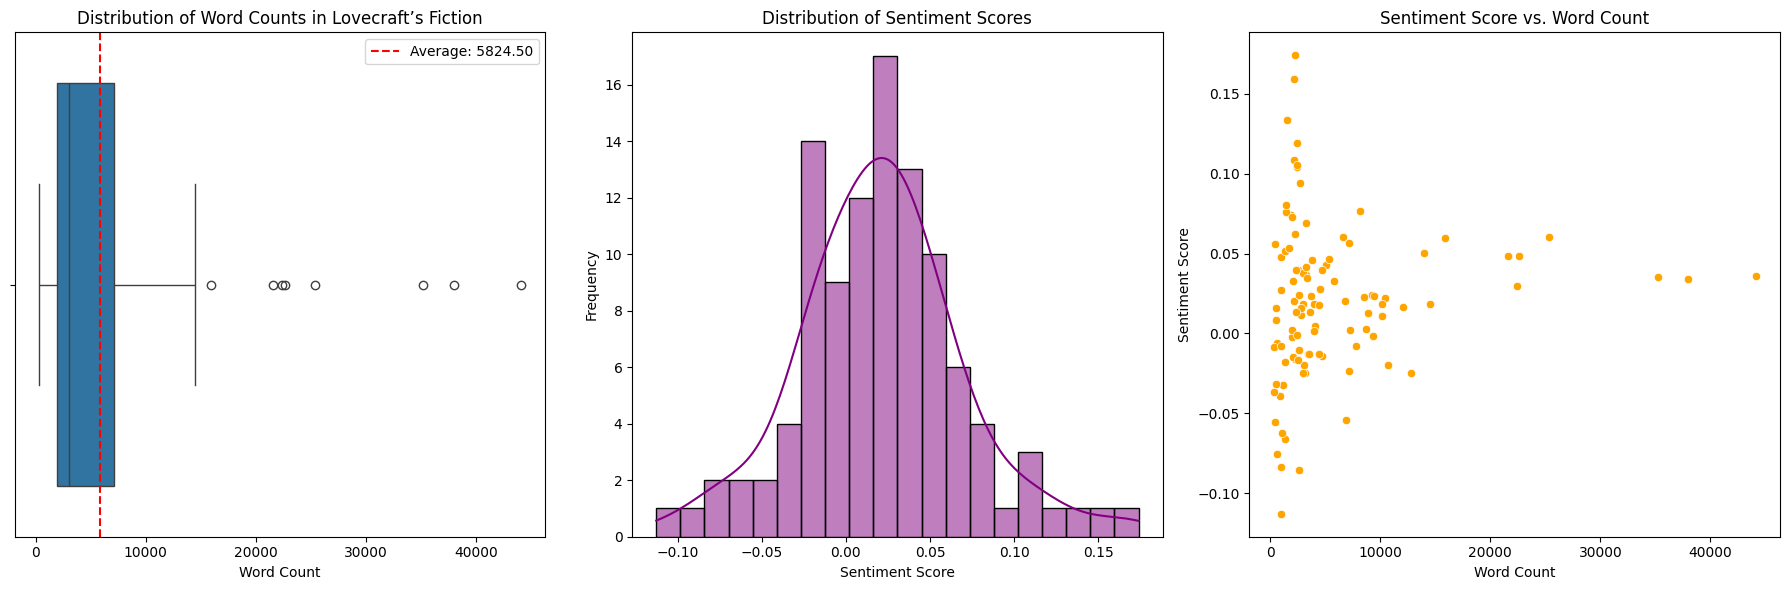

In [8]:
# Figure setup:
plt.figure(figsize=(18, 6))

# Plot 1: Average Word Count Distribution
plt.subplot(1, 3, 1)
sns.boxplot(x=df['Word Count'])
plt.axvline(df['Word Count'].mean(), color='red', linestyle='--', label=f'Average: {df["Word Count"].mean():.2f}')
plt.title('Distribution of Word Counts in Lovecraft’s Fiction')
plt.xlabel('Word Count')
plt.legend()

# Plot 2: Sentiment Score Distribution
plt.subplot(1, 3, 2)
sns.histplot(df['Sentiment'], kde=True, color='purple', bins=20)
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')

# Plot 3: Sentiment vs. Word Count (Bivariate plot)
plt.subplot(1, 3, 3)
sns.scatterplot(x='Word Count', y='Sentiment', data=df, color='orange')
plt.title('Sentiment Score vs. Word Count')
plt.xlabel('Word Count')
plt.ylabel('Sentiment Score')

# Show all plots together:
plt.tight_layout()
plt.show()

# Analysis:

# 1. **Average Word Count Distribution**:
# The first plot shows the distribution of word counts in the dataset. The red dashed line indicates the average word count.
# From this plot, you can observe whether most stories are around the average word count or if there are any extreme values. 
# For example, if there are many outliers, it suggests that some stories are much longer or shorter than the rest.
# This information is useful for understanding the typical length of Lovecraft’s stories and spotting anomalies.

# 2. **Sentiment Score Distribution**:
# The second plot presents the distribution of sentiment scores. The use of a KDE (Kernel Density Estimate) gives us a smooth curve to visualize the overall sentiment.
# If the sentiment score is skewed toward positive or negative values, it could indicate that most stories have a certain mood (negative or neutral).
# This visualization is helpful to understand the general sentiment across all stories. If there's a sharp peak at one end, it suggests a dominant tone in the dataset.

# 3. **Sentiment vs. Word Count**:
# The scatter plot shows how sentiment and word count are related. It’s important to see if longer stories tend to have a more positive or negative sentiment. 
# For instance, if longer stories cluster towards positive sentiment, it might suggest that Lovecraft's longer works have a more optimistic tone, or vice versa.
# This bivariate analysis is useful for identifying trends or correlations between the length of stories and their emotional tone.


In [9]:
# Compute Pearson correlation between Word Count and Sentiment Score:
correlation, p_value = pearsonr(df['Word Count'], df['Sentiment'])
print(f"Pearson's correlation coefficient: {correlation:.2f}")
print(f"P-value: {p_value:.4f}")

# Interpret p-value:
if p_value < 0.05:
    print("The correlation is statistically significant.")
else:
    print("The correlation is not statistically significant.")


Pearson's correlation coefficient: 0.11
P-value: 0.2508
The correlation is not statistically significant.


In [10]:
# Download stopwords:
nltk.download('stopwords')

# Tokenize and remove stopwords:
def clean_text(text):
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    cleaned_tokens = [word.lower() for word in tokens if word.isalnum() and word.lower() not in stop_words]
    return " ".join(cleaned_tokens)

# Apply to text column in DF:
df['Cleaned_Text'] = df['Text'].apply(clean_text)


[nltk_data] Downloading package stopwords to C:\Users\Marc
[nltk_data]     Jay/nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [11]:
# Create frequency distribution for words:
all_words = " ".join(df['Cleaned_Text']).split()
word_freq = Counter(all_words)

# Display most common words:
print(word_freq.most_common(100))


[('could', 2308), ('one', 2066), ('would', 1816), ('old', 1367), ('seemed', 1165), ('time', 1126), ('great', 1041), ('even', 1034), ('must', 1004), ('man', 992), ('saw', 971), ('though', 968), ('like', 955), ('things', 921), ('found', 872), ('came', 861), ('might', 790), ('upon', 789), ('thing', 754), ('made', 753), ('long', 733), ('whose', 722), ('never', 721), ('still', 716), ('strange', 712), ('night', 694), ('much', 684), ('place', 670), ('first', 665), ('knew', 653), ('see', 650), ('come', 645), ('back', 644), ('last', 640), ('men', 638), ('certain', 622), ('many', 622), ('thought', 622), ('know', 615), ('yet', 593), ('something', 592), ('beyond', 573), ('two', 573), ('heard', 571), ('house', 567), ('black', 558), ('told', 548), ('way', 547), ('world', 543), ('almost', 543), ('seen', 543), ('little', 539), ('said', 539), ('ever', 525), ('since', 518), ('new', 518), ('felt', 517), ('left', 509), ('far', 509), ('away', 487), ('dark', 484), ('years', 483), ('room', 482), ('day', 479)

In [12]:
# Load spaCy model for Entity Recognition:
nlp = spacy.load("en_core_web_sm")

# List of Lovecraftian entities:
lovecraftian_entities = [
    'cthulhu', 'nyarlathotep', 'azathoth', 'hastur', 'dagon', 'shub-niggurath', 'tor-gasukk', 
    'yog-sothoth', 'moloch', "kai'lizakia", 'lloigor', 'derleth', 'gog', 'magog', "to'koth", 
    "karnas'koi", 'traguam', "mi'en kalarash", 'kwundaar', 'volund', "k'thun", 'noth-yidik', 
    "tru'nembra", 'tulzscha', 'cxaxukluth', "d'endrrah", 'ubbo-sathla', 'xexanoth', 'ycnàgnnisssz',
    'yhoundeh', 'aiueb gnshal', 'aletheia', 'azhorra-tha', "c'thalpa", 'daoloth', 'ghroth', 'gi-hoveg', 
    'haiogh-yai', 'huitloxopetl', 'ialdagorth', "kaajh'kaalbh", 'kaalut', 'lu-kthu', "mh'ithrha", 
    'mlandoth', 'mril thorion', 'nhimbaloth', 'ngyr-khorath', 'nyctelios', 'olkoth', 'ramasekva', 
    'shabbith-ka', 'suc\'naath', 'uvhash', "xa'ligha", 'yibb-tstll', 'yidhra', "yomag'n'tho"
]

# Indirect references or variations:
indirect_references = [
    r"\bdeep ones\b", r"\bcosmic entity\b", r"\bhorrible being\b", r"\bnight gaunts\b", r"\bblack stone\b",
    r"\byog sothoth\b", r"\bnamesless city\b", r"\bstrange entity\b", r"\botherworldly creature\b", r"\bdark god\b",
    r"\bhorrible power\b", r"\btimeless one\b", r"\bcult of cthulhu\b", r"\bancient god\b", r"\bbeyond time\b",
    r"\beldritch horror\b", r"\bunspeakable entity\b", r"\bforbidden knowledge\b", r"\bunknown terror\b",
    r"\bchaos god\b", r"\bblind idiot god\b", r"\bblind demon\b", r"\bblind idiot\b", r"\bblind god\b",
    r"\bstar spawn\b", r"\bstar gods\b", r"\bstar beings\b", r"\bstar creatures\b", r"\bstar entities\b",
    r"\bancient ones\b", r"\belders\b", r"\bgreat old ones\b", r"\bgreat ones\b", r"\botherworldly beings\b",
    r"\bcosmic power\b", r"\beldritch entity\b", r"\bforbidden deity\b", r"\botherworldly presence\b",
    r"\bhorrific power\b", r"\botherworldly evil\b", r"\bancient forces\b", r"\bunnamable god\b",
    r"\bforbidden knowledge\b", r"\bshapeless horror\b", r"\bhorrible mind\b", r"\bbeyond comprehension\b",
    r"\botherworldly force\b", r"\bunfathomable entity\b", r"\bvoid entity\b", r"\bhorrific eldritch power\b",
    r"\bdark unknown force\b", r"\bprimordial chaos\b", r"\bprimordial entity\b", r"\bmaddening entity\b",
    r"\bdivine horror\b", r"\bdark presence\b", r"\bcosmic horror\b", r"\bgreat nightmare\b",
    r"\bhorrible night\b", r"\bgod of the void\b", r"\bmaddening mind\b", r"\bthe void\b", r"\bbeast of darkness\b"
]


# Function to extract entities, both direct and indirect:
def extract_entities(text):
    doc = nlp(text)
    
    # Initialize list to store extracted entities:
    entities = []

    # Check for direct entity mentions (singular and plural):
    for entity in lovecraftian_entities:
        singular_entity = r'\b' + re.escape(entity) + r'\b'
        plural_entity = r'\b' + re.escape(entity + "s") + r'\b'

        if re.search(singular_entity, text.lower()) or re.search(plural_entity, text.lower()):
            entities.append(entity)
    
    # Check for indirect references or variations:
    for pattern in indirect_references:
        if re.search(pattern, text.lower()):
            entities.extend(lovecraftian_entities)

    return entities

# Apply extraction to 'Cleaned_Text' column:
df['Entities'] = df['Cleaned_Text'].apply(extract_entities)

# Flatten list of entities and get their frequency count:
all_entities = [entity for sublist in df['Entities'] for entity in sublist]
entity_freq = Counter(all_entities)

# Display most common entities:
print(entity_freq.most_common(100))

# Custom list of Lovecraftian entities to track:
specific_entity_freq = {entity: all_entities.count(entity) for entity in lovecraftian_entities}

# Display count of specific entities:
print(specific_entity_freq)


[('cthulhu', 46), ('nyarlathotep', 45), ('azathoth', 42), ('dagon', 40), ('hastur', 38), ('moloch', 38), ('derleth', 38), ('shub-niggurath', 37), ('tor-gasukk', 37), ('yog-sothoth', 37), ("kai'lizakia", 37), ('lloigor', 37), ('gog', 37), ('magog', 37), ("to'koth", 37), ("karnas'koi", 37), ('traguam', 37), ("mi'en kalarash", 37), ('kwundaar', 37), ('volund', 37), ("k'thun", 37), ('noth-yidik', 37), ("tru'nembra", 37), ('tulzscha', 37), ('cxaxukluth', 37), ("d'endrrah", 37), ('ubbo-sathla', 37), ('xexanoth', 37), ('ycnàgnnisssz', 37), ('yhoundeh', 37), ('aiueb gnshal', 37), ('aletheia', 37), ('azhorra-tha', 37), ("c'thalpa", 37), ('daoloth', 37), ('ghroth', 37), ('gi-hoveg', 37), ('haiogh-yai', 37), ('huitloxopetl', 37), ('ialdagorth', 37), ("kaajh'kaalbh", 37), ('kaalut', 37), ('lu-kthu', 37), ("mh'ithrha", 37), ('mlandoth', 37), ('mril thorion', 37), ('nhimbaloth', 37), ('ngyr-khorath', 37), ('nyctelios', 37), ('olkoth', 37), ('ramasekva', 37), ('shabbith-ka', 37), ("suc'naath", 37), (

In [13]:
from collections import Counter

# List of entities with counts:
entities = [
    ('cthulhu', 46), ('nyarlathotep', 45), ('azathoth', 42), ('dagon', 40), ('hastur', 38), 
    ('moloch', 38), ('derleth', 38), ('shub-niggurath', 37), ('tor-gasukk', 37), ('yog-sothoth', 37),
    ("kai'lizakia", 37), ('lloigor', 37), ('gog', 37), ('magog', 37), ("to'koth", 37), ("karnas'koi", 37), 
    ('traguam', 37), ("mi'en kalarash", 37), ('kwundaar', 37), ('volund', 37), ("k'thun", 37), ('noth-yidik', 37), 
    ("tru'nembra", 37), ('tulzscha', 37), ('cxaxukluth', 37), ("d'endrrah", 37), ('ubbo-sathla', 37), ('xexanoth', 37),
    ('ycnàgnnisssz', 37), ('yhoundeh', 37), ('aiueb gnshal', 37), ('aletheia', 37), ('azhorra-tha', 37),
    ("c'thalpa", 37), ('daoloth', 37), ('ghroth', 37), ('gi-hoveg', 37), ('haiogh-yai', 37),
    ('huitloxopetl', 37), ('ialdagorth', 37), ("kaajh'kaalbh", 37), ('kaalut', 37), ('lu-kthu', 37),
    ("mh'ithrha", 37), ('mlandoth', 37), ('mril thorion', 37), ('nhimbaloth', 37), ('ngyr-khorath', 37),
    ('nyctelios', 37), ('olkoth', 37), ('ramasekva', 37), ('shabbith-ka', 37), ('suc\'naath', 37),
    ('uvhash', 37), ("xa'ligha", 37), ('yibb-tstll', 37), ('yidhra', 37), ("yomag'n'tho", 37)
]

# Function to filter and categorize entities:
def filter_lovecraft_entities(entities):
    # Dictionary to store entities by category:
    categories = {
        'Cthulhu Mythos': [],
        'Cosmic Entities': [],
    }

    # Known classifications:
    mythos_deities = {'cthulhu', 'nyarlathotep', 'azathoth', 'shub-niggurath', 
                      'dagon', 'yog-sothoth', 'hastur', 'ubbo-sathla', 'ghroth', 'ycnàgnnisssz'}
    
    cosmic_entities = {'tulzscha', 'cxaxukluth', 'yhoundeh', 
                       'aiueb gnshal', 'aletheia', 'azhorra-tha', "c'thalpa", 'daoloth', 'ghroth', 'gi-hoveg', 
                       'haiogh-yai', 'huitloxopetl', 'ialdagorth', "kaajh'kaalbh", 'kaalut', 'lu-kthu', 
                       "mh'ithrha", 'mlandoth', 'mril thorion', 'nhimbaloth', 'moloch', 'kwundaar', 'volund', 'noth-yidik', 'tru\'nembra'
                       'ngyr-khorath', 'nyctelios', 'olkoth', 'ramasekva', 'shabbith-ka', "suc'naath", 'uvhash', "xa'ligha", 'yibb-tstll', 'yidhra', "yomag'n'tho"}
    
    # Categorize entities:
    for entity, mentions in entities:

        if entity in mythos_deities:
            categories['Cthulhu Mythos'].append((entity, mentions))
        elif entity in cosmic_entities:
            categories['Cosmic Entities'].append((entity, mentions))

    return categories

# Apply filter:
filtered_entities = filter_lovecraft_entities(entities)

# Print result:
for category, entities_list in filtered_entities.items():
    print(f"--- {category} ---")
    for entity, mentions in entities_list:
        print(f"{entity}: {mentions}")


--- Cthulhu Mythos ---
cthulhu: 46
nyarlathotep: 45
azathoth: 42
dagon: 40
hastur: 38
shub-niggurath: 37
yog-sothoth: 37
ubbo-sathla: 37
ycnàgnnisssz: 37
ghroth: 37
--- Cosmic Entities ---
moloch: 38
kwundaar: 37
volund: 37
noth-yidik: 37
tulzscha: 37
cxaxukluth: 37
yhoundeh: 37
aiueb gnshal: 37
aletheia: 37
azhorra-tha: 37
c'thalpa: 37
daoloth: 37
gi-hoveg: 37
haiogh-yai: 37
huitloxopetl: 37
ialdagorth: 37
kaajh'kaalbh: 37
kaalut: 37
lu-kthu: 37
mh'ithrha: 37
mlandoth: 37
mril thorion: 37
nhimbaloth: 37
nyctelios: 37
olkoth: 37
ramasekva: 37
shabbith-ka: 37
suc'naath: 37
uvhash: 37
xa'ligha: 37
yibb-tstll: 37
yidhra: 37
yomag'n'tho: 37


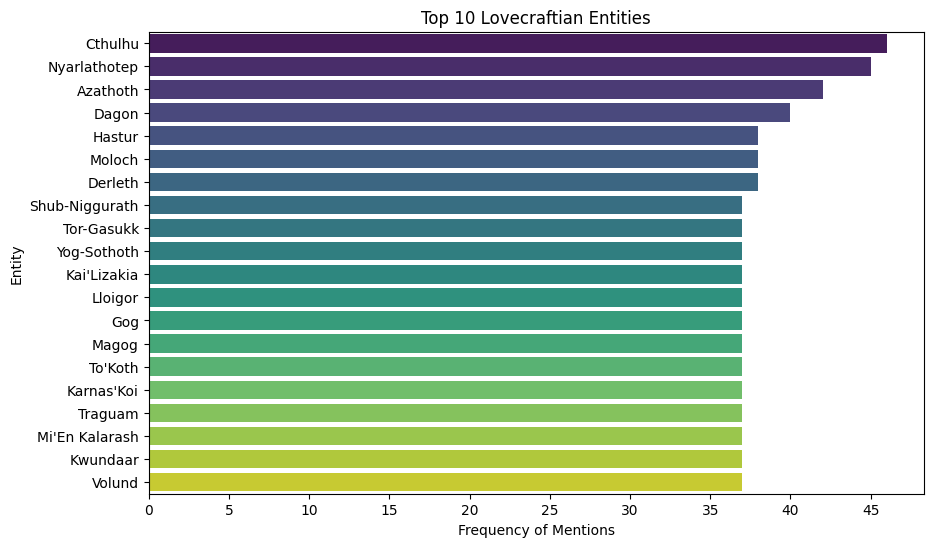

In [14]:
# Count mentions of each entity across all rows in Entities column:
all_entities = [entity for sublist in df['Entities'] for entity in sublist]
entity_mentions = Counter(all_entities)

# Convert Counter object to DF (top 10):
entity_df = pd.DataFrame(entity_mentions.most_common(20), columns=['Entity', 'Frequency'])

# Capitalize first letter of each word in the entity names:
entity_df['Entity'] = entity_df['Entity'].apply(lambda x: x.title())

# Plot top 10 entities:
plt.figure(figsize=(10, 6))
sns.barplot(x='Frequency', y='Entity', data=entity_df, palette='viridis', hue='Entity')
plt.title('Top 10 Lovecraftian Entities')
plt.xlabel('Frequency of Mentions')
plt.ylabel('Entity')

# Set x-axis to show integer values without decimals:
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

plt.show()

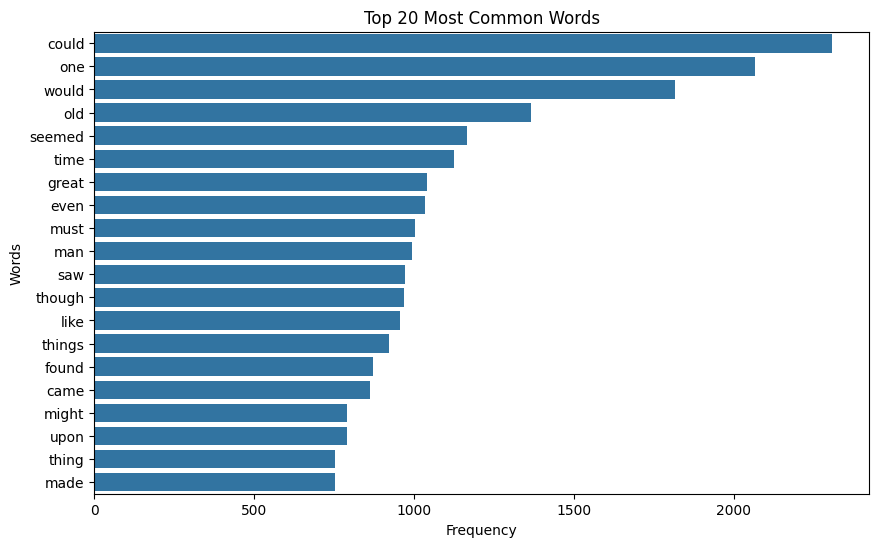

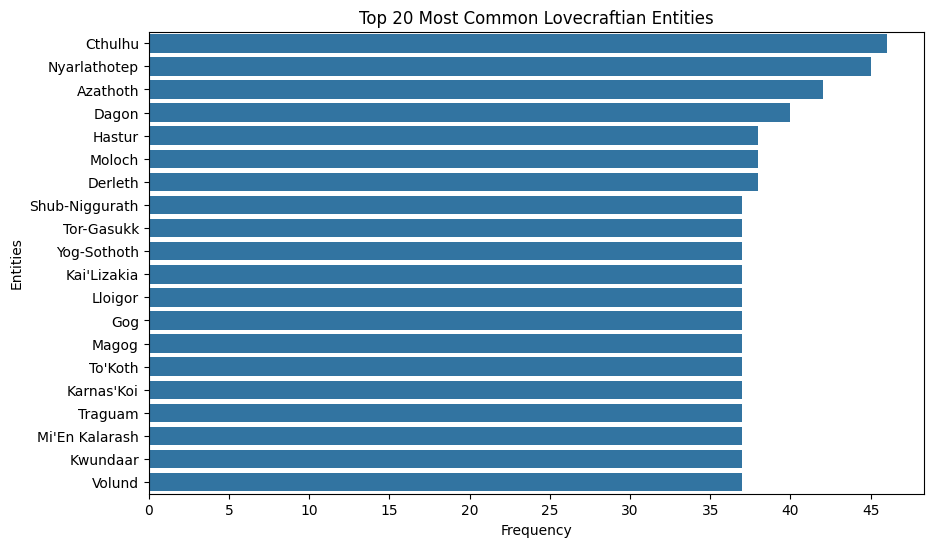

In [15]:
# Plot most common words (word frequency analysis):
top_words = word_freq.most_common(20)
words, counts = zip(*top_words)
plt.figure(figsize=(10, 6))
sns.barplot(y=list(words), x=list(counts))
plt.title('Top 20 Most Common Words')
plt.ylabel('Words')
plt.xlabel('Frequency')
plt.show()

# Plot most common entities:
top_entities = entity_freq.most_common(20)
entities, entity_counts = zip(*top_entities)

# Capitalize first letter of each word in entity names:
entities = [entity.title() for entity in entities]

plt.figure(figsize=(10, 6))
sns.barplot(y=list(entities), x=list(entity_counts))
plt.title('Top 20 Most Common Lovecraftian Entities')
plt.ylabel('Entities')
plt.xlabel('Frequency')

# Set x-axis to show integer values without decimals:
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

plt.show()
